In [1]:
import os, time
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision import transforms, datasets
import matplotlib.pyplot as plt

In [29]:
torch.manual_seed(42)  
random_arr = torch.rand(2,3,4)
random_arr

tensor([[[0.8823, 0.9150, 0.3829, 0.9593],
         [0.3904, 0.6009, 0.2566, 0.7936],
         [0.9408, 0.1332, 0.9346, 0.5936]],

        [[0.8694, 0.5677, 0.7411, 0.4294],
         [0.8854, 0.5739, 0.2666, 0.6274],
         [0.2696, 0.4414, 0.2969, 0.8317]]])

In [43]:
random_arr.argmin(dim=2).shape

torch.Size([2, 3])

In [48]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465),  # mean of CIFAR-10 images
                         (0.2470, 0.2435, 0.2616))   # std of CIFAR-10 images
])
train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=100, shuffle=False)


100%|██████████| 170M/170M [00:26<00:00, 6.41MB/s] 


Epoch 1, Step 0, Loss=2.2922
Epoch 1, Step 100, Loss=2.2312
Epoch 1, Step 200, Loss=1.9741
Epoch 1, Step 300, Loss=1.8034
Epoch 1, Step 400, Loss=1.7755
*** Iteration 500: Train Loss=1.7014, Train Acc=0.367, Test Loss=1.6201, Test Acc=0.395 ***
Epoch 1, Step 500, Loss=1.8323
Epoch 1, Step 600, Loss=1.3495
Epoch 1, Step 700, Loss=1.6877
Epoch 1, Step 800, Loss=1.2122
Epoch 1, Step 900, Loss=1.2614
*** Iteration 1000: Train Loss=1.4352, Train Acc=0.494, Test Loss=1.3756, Test Acc=0.497 ***
Epoch 1, Step 1000, Loss=1.1549
Epoch 1, Step 1100, Loss=1.4484
Epoch 1, Step 1200, Loss=0.8617
Epoch 1, Step 1300, Loss=1.2065
Epoch 1, Step 1400, Loss=1.1911
*** Iteration 1500: Train Loss=1.2217, Train Acc=0.567, Test Loss=1.1978, Test Acc=0.578 ***
Epoch 1, Step 1500, Loss=1.0248
*** Iteration 1563: Train Loss=1.2115, Train Acc=0.559, Test Loss=1.2460, Test Acc=0.556 ***
Training finished in 31.6 seconds. Plots saved to accuracies.png and losses.png.


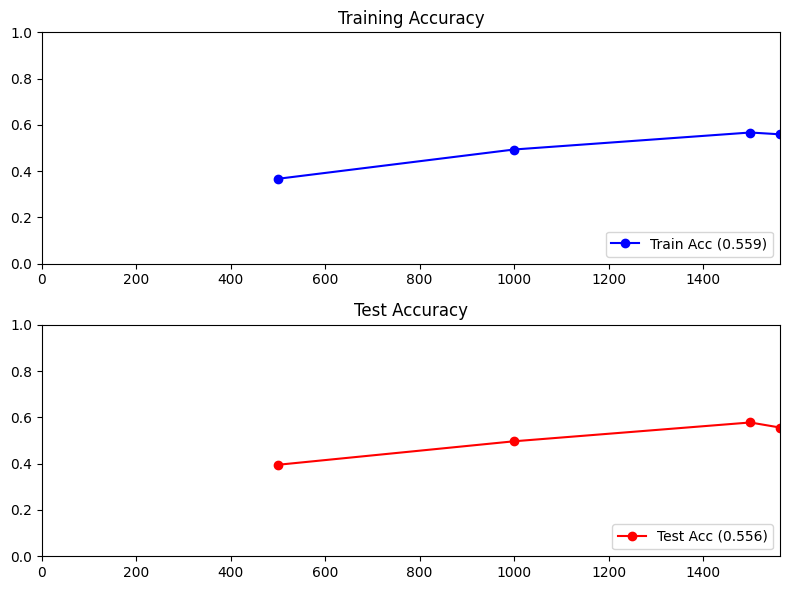

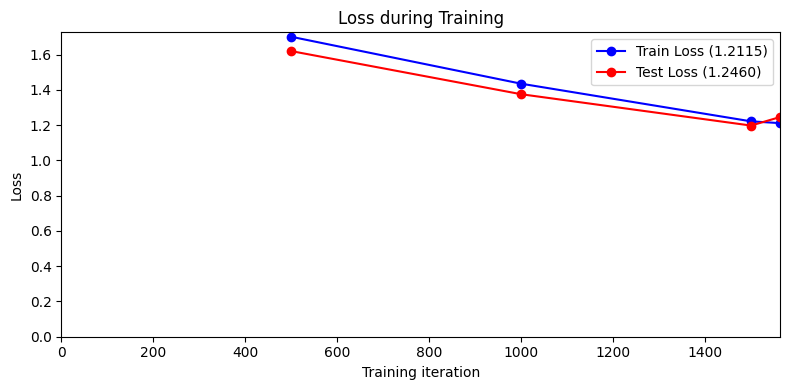

In [50]:
import os, time
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision import transforms, datasets
import matplotlib.pyplot as plt

# Hyperparameters (from original defaults)
d_model = 512        # model hidden dimension:contentReference[oaicite:3]{index=3}
d_input = 128        # input feature dimension:contentReference[oaicite:4]{index=4}
iterations = 50      # internal iterations (ticks):contentReference[oaicite:5]{index=5}
heads = 4            # attention heads (not explicitly used in this minimal implementation):contentReference[oaicite:6]{index=6}
batch_size = 32      # training batch size:contentReference[oaicite:7]{index=7}
lr = 1e-3            # learning rate:contentReference[oaicite:8]{index=8}
weight_decay = 0.0   # weight decay (as in original default):contentReference[oaicite:9]{index=9}
warmup_steps = 5000  # warmup steps for LR scheduler:contentReference[oaicite:10]{index=10}
total_steps = None   # will be set to len(train_loader)*epochs
use_scheduler = True
# We train for a small number of iterations: here 1 epoch for quick testing.
epochs = 1
track_every = 500    # evaluate/plot every 500 training steps (approx twice per epoch)
n_eval_batches = 20  # number of minibatches to use for metric evaluation (approximate, like original:contentReference[oaicite:11]{index=11})

# CIFAR-10 Data loading
mean = (0.4914, 0.4822, 0.4465)  # CIFAR-10 training set mean (RGB)
std = (0.2470, 0.2435, 0.2616)   # CIFAR-10 training set std
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])
train_data = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
test_data  = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True)
test_loader  = torch.utils.data.DataLoader(test_data, batch_size=batch_size, shuffle=False)
total_steps = len(train_loader) * epochs

# Define the Continuous Thought Machine (CTM) model
class ContinuousThoughtMachine(nn.Module):
    def __init__(self, d_model, d_input, out_dims, iterations):
        super().__init__()
        # Backbone: a simple two-layer CNN to produce d_input features from 32x32 images
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.pool1 = nn.MaxPool2d(2, 2)   # 32->16
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.pool2 = nn.MaxPool2d(2, 2)   # 16->8
        self.fc_feat = nn.Linear(64 * 8 * 8, d_input)
        # Recurrent transformation and output layers
        self.W_h = nn.Linear(d_model, d_model)   # hidden-to-hidden
        self.W_x = nn.Linear(d_input, d_model)   # input-to-hidden
        self.out = nn.Linear(d_model, out_dims)  # class logits
        self.out_c = nn.Linear(d_model, 1)       # certainty score
        self.iterations = iterations
        self.activation = nn.Tanh()
    def forward(self, x):
        B = x.size(0)
        # Feature extractor
        x = self.pool1(torch.relu(self.conv1(x)))    # -> [B,32,16,16]
        x = self.pool2(torch.relu(self.conv2(x)))    # -> [B,64,8,8]
        feats = torch.relu(self.fc_feat(x.view(B, -1)))  # -> [B, d_input]
        # Initialize hidden state from input features
        h = self.activation(self.W_x(feats))
        preds = []
        certs = []
        # Iterative thinking loop
        for t in range(self.iterations):
            # Recurrent update (add input each time for observation synch)
            h = self.activation(self.W_h(h) + self.W_x(feats))
            # Record output predictions and certainty at this step
            preds.append(self.out(h))             # [B, out_dims]
            certs.append(self.out_c(h).squeeze(-1))  # [B]
        # Stack over time
        preds = torch.stack(preds, dim=2)   # [B, out_dims, T]
        certs = torch.stack(certs, dim=1)   # [B, T]
        return preds, certs, None

# Initialize model, optimizer, and loss
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = ContinuousThoughtMachine(d_model, d_input, out_dims=10, iterations=iterations).to(device)
optimizer = optim.AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)
criterion = nn.CrossEntropyLoss()

# Learning rate schedule: warmup + cosine decay to 0
def get_lr_factor(step):
    if step < warmup_steps:
        return step / float(max(1, warmup_steps))  # linear warmup
    # Cosine annealing (drop to 0 at final step)
    progress = (step - warmup_steps) / float(max(1, total_steps - warmup_steps))
    return 0.5 * (1.0 + torch.cos(torch.tensor(progress * 3.1415926535)))  # cos(pi*progress)
# (We will update optimizer.lr manually using this schedule each step)

# Training loop with periodic evaluation
train_losses, test_losses = [], []
train_accs, test_accs = [], []
iters = []
global_step = 0
start_time = time.time()
for epoch in range(epochs):
    model.train()
    for batch_idx, (inputs, targets) in enumerate(train_loader):
        inputs, targets = inputs.to(device), targets.to(device)
        global_step += 1
        # Forward pass
        preds, certs, _ = model(inputs)
        # Compute loss using the most certain prediction at each sample
        # Find index of most certain step for each sample
        cert_idx = certs.argmax(dim=1)            # [B]
        # Select the logits corresponding to the most certain step for each sample
        preds_transposed = preds.permute(0, 2, 1)  # [B, T, out_dims]
        chosen_logits = preds_transposed[torch.arange(inputs.size(0)), cert_idx]  # [B, out_dims]
        loss = criterion(chosen_logits, targets)
        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        # Scheduler step
        if use_scheduler:
            lr_factor = float(get_lr_factor(global_step))
            for param_group in optimizer.param_groups:
                param_group['lr'] = lr * lr_factor
        # Print progress occasionally
        if batch_idx % 100 == 0:
            print(f"Epoch {epoch+1}, Step {batch_idx}, Loss={loss.item():.4f}")
        # Evaluation and plotting metrics at intervals
        if global_step % track_every == 0 or (epoch == epochs-1 and batch_idx == len(train_loader)-1):
            model.eval()
            # Evaluate on a subset of training data
            total, correct = 0, 0
            total_loss = 0.0
            eval_batches = 0
            with torch.no_grad():
                for i, (x, y) in enumerate(train_loader):
                    x, y = x.to(device), y.to(device)
                    preds_val, certs_val, _ = model(x)
                    ci = certs_val.argmax(dim=1)
                    preds_val = preds_val.permute(0, 2, 1)[torch.arange(x.size(0)), ci]
                    loss_val = criterion(preds_val, y)
                    total_loss += loss_val.item() * x.size(0)
                    pred_labels = preds_val.argmax(dim=1)
                    correct += (pred_labels == y).sum().item()
                    total += x.size(0)
                    eval_batches += 1
                    if eval_batches >= n_eval_batches:  # limit number of batches for speed
                        break
            train_loss_avg = total_loss / total
            train_acc = correct / total
            # Evaluate on a subset of test data
            total, correct = 0, 0
            total_loss = 0.0
            eval_batches = 0
            for i, (x, y) in enumerate(test_loader):
                x, y = x.to(device), y.to(device)
                preds_val, certs_val, _ = model(x)
                ci = certs_val.argmax(dim=1)
                preds_val = preds_val.permute(0, 2, 1)[torch.arange(x.size(0)), ci]
                loss_val = criterion(preds_val, y)
                total_loss += loss_val.item() * x.size(0)
                pred_labels = preds_val.argmax(dim=1)
                correct += (pred_labels == y).sum().item()
                total += x.size(0)
                eval_batches += 1
                if eval_batches >= n_eval_batches:
                    break
            test_loss_avg = total_loss / total
            test_acc = correct / total
            # Record metrics
            iters.append(global_step)
            train_losses.append(train_loss_avg)
            test_losses.append(test_loss_avg)
            train_accs.append(train_acc)
            test_accs.append(test_acc)
            # Print metrics
            print(f"*** Iteration {global_step}: Train Loss={train_loss_avg:.4f}, Train Acc={train_acc:.3f}, "
                  f"Test Loss={test_loss_avg:.4f}, Test Acc={test_acc:.3f} ***")
            model.train()
# End of training

# Plot accuracy curves
fig1 = plt.figure(figsize=(8,6))
ax1 = fig1.add_subplot(2, 1, 1)
ax2 = fig1.add_subplot(2, 1, 2)
ax1.plot(iters, train_accs, 'b-o', label=f'Train Acc ({train_accs[-1]:.3f})')
ax2.plot(iters, test_accs, 'r-o', label=f'Test Acc ({test_accs[-1]:.3f})')
ax1.set_title('Training Accuracy'); ax2.set_title('Test Accuracy')
ax1.legend(loc='lower right'); ax2.legend(loc='lower right')
ax1.set_xlim([0, total_steps]); ax2.set_xlim([0, total_steps])
ax1.set_ylim([0, 1.0]); ax2.set_ylim([0, 1.0])
fig1.tight_layout()
fig1.savefig('accuracies.png', dpi=150)

# Plot loss curves
fig2 = plt.figure(figsize=(8,4))
ax = fig2.add_subplot(1,1,1)
ax.plot(iters, train_losses, 'b-o', label=f'Train Loss ({train_losses[-1]:.4f})')
ax.plot(iters, test_losses, 'r-o', label=f'Test Loss ({test_losses[-1]:.4f})')
ax.set_title('Loss during Training')
ax.set_xlabel('Training iteration'); ax.set_ylabel('Loss')
ax.legend(loc='upper right')
ax.set_xlim([0, total_steps]); ax.set_ylim(bottom=0.0)
fig2.tight_layout()
fig2.savefig('losses.png', dpi=150)

print(f"Training finished in {time.time()-start_time:.1f} seconds. Plots saved to accuracies.png and losses.png.")


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import time
import os
from collections import deque

# Ensure the 'results' directory exists for saving plots and models
os.makedirs('results', exist_ok=True)

# --- 1. Configuration ---
# All hyperparameters are consolidated here for easy modification.
# These values are based on the descriptions for CIFAR-10 training
# in the CTM repository's scripts.[9]
class CTMConfig:
    # --- Dataset and Dataloader ---
    DATASET = 'cifar10'
    DATA_ROOT = './data'
    BATCH_SIZE = 128
    NUM_WORKERS = 2

    # --- Model Architecture ---
    N_NEURONS = 512  # Number of neurons in the CTM core
    N_TICKS = 16     # Number of internal "thought" steps (T)
    TEMPORAL_DEPTH = 4 # History of pre-activations for NLMs
    INPUT_CHANNELS = 3 # For CIFAR-10 RGB images
    NUM_CLASSES = 10   # For CIFAR-10

    # --- Training ---
    EPOCHS = 50
    LEARNING_RATE = 1e-4
    WEIGHT_DECAY = 1e-4
    OPTIMIZER = 'AdamW'
    DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

# --- 2. Model Definitions ---

class SynapseModel(nn.Module):
    """
    A simple CNN to process the input image and generate initial pre-activations.
    This acts as a feature extractor before the CTM's temporal processing.
    """
    def __init__(self, in_channels, out_features):
        super().__init__()
        self.network = nn.Sequential(
            nn.Conv2d(in_channels, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # 32x32 -> 16x16
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # 16x16 -> 8x8
            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # 8x8 -> 4x4
            nn.Flatten(),
            nn.Linear(256 * 4 * 4, out_features)
        )

    def forward(self, x):
        return self.network(x)

class NeuronLevelModel(nn.Module):
    """
    The Neuron-Level Model (NLM). Each neuron has its own private MLP
    that processes a history of its pre-activations.
    """
    def __init__(self, n_neurons, temporal_depth):
        super().__init__()
        # Each of the n_neurons gets its own linear layer.
        # This is implemented as a single large linear layer for efficiency.
        # Input: (B, N, D_temp), Output: (B, N, 1)
        # where B=batch, N=n_neurons, D_temp=temporal_depth
        self.n_neurons = n_neurons
        self.temporal_depth = temporal_depth
        # A 2-layer MLP for each neuron
        self.mlp = nn.Sequential(
            nn.Linear(temporal_depth, 32),
            nn.ReLU(),
            nn.Linear(32, 1)
        )
        # We need to apply this MLP per-neuron. A grouped convolution is a
        # computationally efficient way to achieve this.
        self.neuron_mlps = nn.Conv1d(
            in_channels=self.n_neurons * self.temporal_depth,
            out_channels=self.n_neurons, # Output is one value per neuron
            kernel_size=1,
            groups=self.n_neurons
        )
        self.activation = nn.Tanh() # To keep post-activations bounded

    def forward(self, pre_activation_history):
        # pre_activation_history shape: (B, D_temp, N)
        B, D_temp, N = pre_activation_history.shape
        
        # Reshape for per-neuron processing with Conv1d
        # (B, D_temp, N) -> (B, N, D_temp)
        x = pre_activation_history.permute(0, 2, 1)
        # (B, N, D_temp) -> (B, N * D_temp, 1)
        x = x.reshape(B, N * D_temp, 1)

        # Apply the per-neuron MLPs
        post_activations = self.neuron_mlps(x) # (B, N, 1)
        post_activations = post_activations.squeeze(-1) # (B, N)

        return self.activation(post_activations)

class ContinuousThoughtMachine(nn.Module):
    """
    The main CTM model. Integrates the SynapseModel and NeuronLevelModel
    and runs the internal "tick" loop.
    """
    def __init__(self, config):
        super().__init__()
        self.config = config
        self.n_neurons = config.N_NEURONS
        self.n_ticks = config.N_TICKS
        self.temporal_depth = config.TEMPORAL_DEPTH
        self.num_classes = config.NUM_CLASSES

        # Input feature extractor
        self.synapse_model = SynapseModel(config.INPUT_CHANNELS, self.n_neurons)
        
        # Per-neuron temporal processing
        self.nlm = NeuronLevelModel(self.n_neurons, self.temporal_depth)

        # Output projection from the synchronization matrix
        # The synchronization matrix is (n_neurons x n_neurons). We flatten it.
        self.output_projection = nn.Linear(self.n_neurons * self.n_neurons, self.num_classes)

    def forward(self, x, return_internals=False):
        batch_size = x.shape
        device = x.device

        # --- Initialize Histories ---
        # Pre-activation history (A_t): a buffer of the last `temporal_depth` pre-activations
        pre_activation_history = deque(
            [torch.zeros(batch_size, self.n_neurons, device=device) for _ in range(self.temporal_depth)],
            maxlen=self.temporal_depth
        )
        # Post-activation history (Z_t): collects all post-activations over ticks
        post_activation_history =

        # --- Initial pre-activation from input image ---
        # This is a_0, the initial thought stimulus
        initial_pre_activations = self.synapse_model(x)
        pre_activation_history.append(initial_pre_activations)

        # For visualization
        all_logits =
        
        # --- Internal Tick Loop ---
        for t in range(self.n_ticks):
            # 1. Get current pre-activation history tensor
            # Shape: (B, D_temp, N)
            current_pre_history_tensor = torch.stack(list(pre_activation_history), dim=1).permute(0, 2, 1)

            # 2. Neuron-Level Models compute post-activations (z_t)
            post_activations = self.nlm(current_pre_history_tensor) # (B, N)
            post_activation_history.append(post_activations)

            # 3. Compute Synchronization Matrix (S_t)
            # Z_t shape: (B, t+1, N)
            Z_t = torch.stack(post_activation_history, dim=1)
            # S_t = Z_t^T @ Z_t. Shape: (B, N, N)
            S_t = torch.bmm(Z_t.transpose(1, 2), Z_t)

            # 4. Project from synchronization to output logits
            # Flatten the synchronization matrix for the linear layer
            s_flat = S_t.view(batch_size, -1) # (B, N*N)
            logits = self.output_projection(s_flat)
            all_logits.append(logits)

            # 5. Generate next pre-activations (a_{t+1}) for the next tick
            # In a simple setup, we can use the current post-activations as the next pre-activations.
            # More complex models could have another recurrent connection here.
            next_pre_activations = post_activations
            pre_activation_history.append(next_pre_activations)

        # For a minimal implementation, we use the logits from the final tick for loss calculation.
        final_logits = all_logits[-1]

        if return_internals:
            return final_logits, {'all_logits': all_logits}
        return final_logits

# --- 3. Data Handling ---

def get_dataloaders(config):
    """Prepares and returns CIFAR-10 DataLoaders."""
    # Using ImageNet normalization constants is a robust practice [10]
    transform = transforms.Compose(, std=[0.229, 0.224, 0.225])
    ])

    train_dataset = torchvision.datasets.CIFAR10(
        root=config.DATA_ROOT, train=True, download=True, transform=transform
    )
    test_dataset = torchvision.datasets.CIFAR10(
        root=config.DATA_ROOT, train=False, download=True, transform=transform
    )

    train_loader = torch.utils.data.DataLoader(
        train_dataset, batch_size=config.BATCH_SIZE, shuffle=True, num_workers=config.NUM_WORKERS
    )
    test_loader = torch.utils.data.DataLoader(
        test_dataset, batch_size=config.BATCH_SIZE, shuffle=False, num_workers=config.NUM_WORKERS
    )
    
    print("CIFAR-10 DataLoaders created.")
    return train_loader, test_loader

# --- 4. Training and Evaluation ---

def train_epoch(model, dataloader, criterion, optimizer, device):
    """Runs one epoch of training."""
    model.train()
    total_loss = 0.0
    correct_predictions = 0
    total_samples = 0

    for i, (images, labels) in enumerate(dataloader):
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item() * images.size(0)
        _, predicted = torch.max(outputs.data, 1)
        total_samples += labels.size(0)
        correct_predictions += (predicted == labels).sum().item()

    avg_loss = total_loss / total_samples
    accuracy = 100 * correct_predictions / total_samples
    return avg_loss, accuracy

def test_epoch(model, dataloader, criterion, device):
    """Runs one epoch of evaluation."""
    model.eval()
    total_loss = 0.0
    correct_predictions = 0
    total_samples = 0

    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)

            total_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs.data, 1)
            total_samples += labels.size(0)
            correct_predictions += (predicted == labels).sum().item()

    avg_loss = total_loss / total_samples
    accuracy = 100 * correct_predictions / total_samples
    return avg_loss, accuracy

# --- 5. Plotting ---

def plot_metrics(train_losses, val_losses, train_accs, val_accs):
    """Plots and saves the training and validation metrics."""
    epochs = range(1, len(train_losses) + 1)

    plt.figure(figsize=(12, 5))

    # Plot Loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, 'b-o', label='Training Loss')
    plt.plot(epochs, val_losses, 'r-o', label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

    # Plot Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_accs, 'b-o', label='Training Accuracy')
    plt.plot(epochs, val_accs, 'r-o', label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy (%)')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    save_path = os.path.join('results', 'training_metrics.png')
    plt.savefig(save_path)
    print(f"Metrics plot saved to {save_path}")
    plt.show()

# --- 6. Main Execution Block ---

if __name__ == "__main__":
    config = CTMConfig()
    print(f"Using device: {config.DEVICE}")

    # Get data
    train_loader, test_loader = get_dataloaders(config)

    # Initialize model, criterion, and optimizer
    model = ContinuousThoughtMachine(config).to(config.DEVICE)
    print(f"Model initialized with {sum(p.numel() for p in model.parameters()):,} trainable parameters.")
    
    criterion = nn.CrossEntropyLoss()
    
    if config.OPTIMIZER == 'AdamW':
        optimizer = optim.AdamW(model.parameters(), lr=config.LEARNING_RATE, weight_decay=config.WEIGHT_DECAY)
    else: # Default to SGD
        optimizer = optim.SGD(model.parameters(), lr=config.LEARNING_RATE, momentum=0.9)

    # Training loop
    history = {
        'train_loss':, 'val_loss':,
        'train_acc':, 'val_acc':
    }
    best_val_acc = 0.0

    print("\n--- Starting Training ---")
    start_time = time.time()

    for epoch in range(config.EPOCHS):
        train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, config.DEVICE)
        val_loss, val_acc = test_epoch(model, test_loader, criterion, config.DEVICE)

        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)

        print(f"Epoch {epoch+1}/{config.EPOCHS} | "
                f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}% | "
                f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%")

        # Save the best model
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            model_path = os.path.join('results', 'best_ctm_cifar10.pth')
            torch.save(model.state_dict(), model_path)
            print(f"  -> New best model saved to {model_path} (Val Acc: {best_val_acc:.2f}%)")

    end_time = time.time()
    print(f"\n--- Training Finished ---")
    print(f"Total training time: {(end_time - start_time)/60:.2f} minutes")
    print(f"Best validation accuracy: {best_val_acc:.2f}%")

    # Plot results
    plot_metrics(history['train_loss'], history['val_loss'], history['train_acc'], history['val_acc'])

In [51]:
from models.ctm import ContinuousThoughtMachine